ede2110 emile esmaili


Notebook pipeline: 

- Subtype classification with L1-Logit
- Feature importance with SHAP
- Most important genes embedded with BERT
- embeddings dim reduced
- Clustering of reduced embeddings

# TODO

- get table with longer descriptions
- use leiden clustering or other and not kmeans



# Imports

In [15]:
import numpy as np 
import pandas as pd 
import scanpy as sc 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import shap 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.cluster import DBSCAN, KMeans
import seaborn as sns

from sklearn.preprocessing import StandardScaler

sc.settings.verbosity = 3 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer

sc.settings.set_figure_params(dpi = 80)
%matplotlib inline
from Bio import Entrez
import re
from IPython.display import display, Markdown, Latex

In [3]:
# read the gene expression data: 
raw_data_rna = pd.read_table("./data/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt", sep="\t")
raw_data_rna.head(3)

,Hugo_Symbol,Entrez_Gene_Id,TCGA-CS-4938-01,TCGA-CS-4941-01,TCGA-CS-4942-01,TCGA-CS-4943-01,TCGA-CS-4944-01,TCGA-CS-5390-01,TCGA-CS-5393-01,TCGA-CS-5394-01,...,TCGA-VW-A8FI-01,TCGA-W9-A837-01,TCGA-WH-A86K-01,TCGA-WY-A858-01,TCGA-WY-A859-01,TCGA-WY-A85A-01,TCGA-WY-A85B-01,TCGA-WY-A85C-01,TCGA-WY-A85D-01,TCGA-WY-A85E-01
0,NaN,100130426,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,...,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197
1,NaN,100133144,0.1185,2.0342,0.5116,0.1034,-3.1094,-0.4877,-0.8870,0.0577,...,1.1529,0.5938,0.4161,-0.0182,-1.0264,-0.4623,0.0507,0.4778,-0.4763,0.2876
2,UBE2Q2P2,100134869,0.8030,0.6853,-0.3650,-1.5341,1.2744,1.1389,-0.7295,0.1724,...,0.7471,1.0861,0.0440,0.2981,-0.4821,0.2481,0.5676,0.4846,-0.6968,-0.9707


In [4]:
# transpose the data and make the gene id as the column names: 
df_clean = raw_data_rna.set_index("Entrez_Gene_Id").drop("Hugo_Symbol", axis = 1).transpose().dropna(axis=1)
df_clean.head()

Entrez_Gene_Id,100130426,100133144,100134869,10357,10431,155060,26823,280660,340602,388795,...,55055,11130,7789,158586,79364,440590,79699,7791,23140,26009
TCGA-CS-4938-01,-6.6197,0.1185,0.8030,1.9096,1.1627,-1.2910,-1.1661,-24.2671,-0.8905,-0.7464,...,-1.0345,-1.3155,-0.0235,0.7347,0.2169,-1.2143,0.4502,-0.8102,-1.2280,1.0099
TCGA-CS-4941-01,-6.6197,2.0342,0.6853,0.2687,-1.7875,-0.3693,0.5989,-24.2671,-0.2931,-0.8891,...,0.5681,-0.3297,0.9896,0.3312,-0.0860,-0.7410,0.9028,0.9552,0.1514,1.5061
TCGA-CS-4942-01,-6.6197,0.5116,-0.3650,0.7763,-0.0135,-1.8175,-2.1143,-24.2671,-1.0988,-0.8873,...,-0.2736,0.3326,1.1601,0.2281,-0.5701,-0.7399,0.6187,-0.1635,-0.5145,0.5814
TCGA-CS-4943-01,-6.6197,0.1034,-1.5341,1.9239,1.1169,-2.5350,-1.3505,-24.2671,-1.3783,-1.6739,...,2.9808,2.6781,0.6371,0.5073,0.1360,1.0996,0.9174,-0.2393,0.5748,0.5170
TCGA-CS-4944-01,-6.6197,-3.1094,1.2744,1.2506,1.0094,-2.5886,-2.1143,-24.2671,-0.4584,-1.6739,...,-1.6638,-1.1717,-0.8581,-0.9870,-0.9546,-0.5623,-0.1225,-0.6971,-2.9617,-0.5319


## Preprocess pipeline - Genomics + Clinical

In [5]:

## read patient data and preprocessing...

# check the quality of the data: 
# 1) if there is any NA data
print(f"If there is NA values: {df_clean.isnull().values.any()}")

# 2) if there are columns with all the same value
unique_counts = df_clean.nunique()
same_value_cols = unique_counts[unique_counts == 1].index.tolist()



raw_data_sample = pd.read_table("./data/data_clinical_sample.txt", sep="\t")
df_sample2 = pd.read_table("./supplement_data/Clinical_Data.tsv", sep="\t")
raw_data_sample.columns = raw_data_sample.iloc[3,:]
raw_data_sample = raw_data_sample.drop([0,1,2,3], axis = 0)
df_patient = raw_data_sample.reset_index().drop(["index"], axis = 1)
df_full = df_patient.merge(df_sample2, left_on = "PATIENT_ID", right_on = "Patient ID", how = "left")
df_full_1 = df_full.drop(['Patient ID', 'Sample ID','Cancer Type Detailed','Tumor Type', 'Aneuploidy Score'], axis = 1)

df_sample_with_gene = df_clean.merge(df_full_1, left_index=True, right_on = "SAMPLE_ID")
X = df_sample_with_gene.iloc[:,0:-30].copy()
X = X.set_index("PATIENT_ID")
obs = df_sample_with_gene.iloc[:,-31:].copy()
obs = obs.set_index("PATIENT_ID")
adata_sample = sc.AnnData(X, obs = obs)

X= pd.DataFrame(adata_sample.X)
X.columns = adata_sample.var_names
X.index = adata_sample.obs.index
y = adata_sample.obs['Subtype']
df = pd.concat([X,y], axis = 1)

df_drop = df.drop(df[df.Subtype.isnull()].index, axis = 0)

# assign features, target and encoding...
y = df_drop["Subtype"]
X= df_drop.drop("Subtype", axis = 1)

y = y.map({"LGG_IDHmut-non-codel":0, "LGG_IDHwt":1, "LGG_IDHmut-codel":2})


X_train,X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

If there is NA values: False


## Import gene decription

In [6]:
df_gene_reference = pd.read_table("./supplement_data/gene_table.tsv")
df_gene_reference.head()
#df_gene_description = df_clean.merge(df_gene_reference, how = "left", left_on = "Entrez_Gene_Id", right_on = "NCBI GeneID")

# here is the table with the description:
#df_important_gene_description.head(10)

,NCBI GeneID,Symbol,Description,Taxonomic Name,Gene Type,Gene Group Identifier,Gene Group Method
0,7157,TP53,tumor protein p53,Homo sapiens,PROTEIN_CODING,7157.0,NCBI Ortholog
1,1956,EGFR,epidermal growth factor receptor,Homo sapiens,PROTEIN_CODING,1956.0,NCBI Ortholog
2,7124,TNF,tumor necrosis factor,Homo sapiens,PROTEIN_CODING,7124.0,NCBI Ortholog
3,348,APOE,apolipoprotein E,Homo sapiens,PROTEIN_CODING,348.0,NCBI Ortholog
4,7422,VEGFA,vascular endothelial growth factor A,Homo sapiens,PROTEIN_CODING,7422.0,NCBI Ortholog


# Run a simple classification model, get most important genes

In [7]:
clf = LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga')
clf.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', penalty='l1', solver='saga')

In [8]:
# get the model coefficients
coefficients = clf.coef_
intercept = clf.intercept_

y_pred = clf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

print("Train score", clf.score(X_train, y_train), "\nTest Score", clf.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        64
           1       1.00      0.90      0.95        21
           2       1.00      1.00      1.00        42

    accuracy                           0.98       127
   macro avg       0.99      0.97      0.98       127
weighted avg       0.98      0.98      0.98       127

Train score 1.0 
Test Score 0.984251968503937


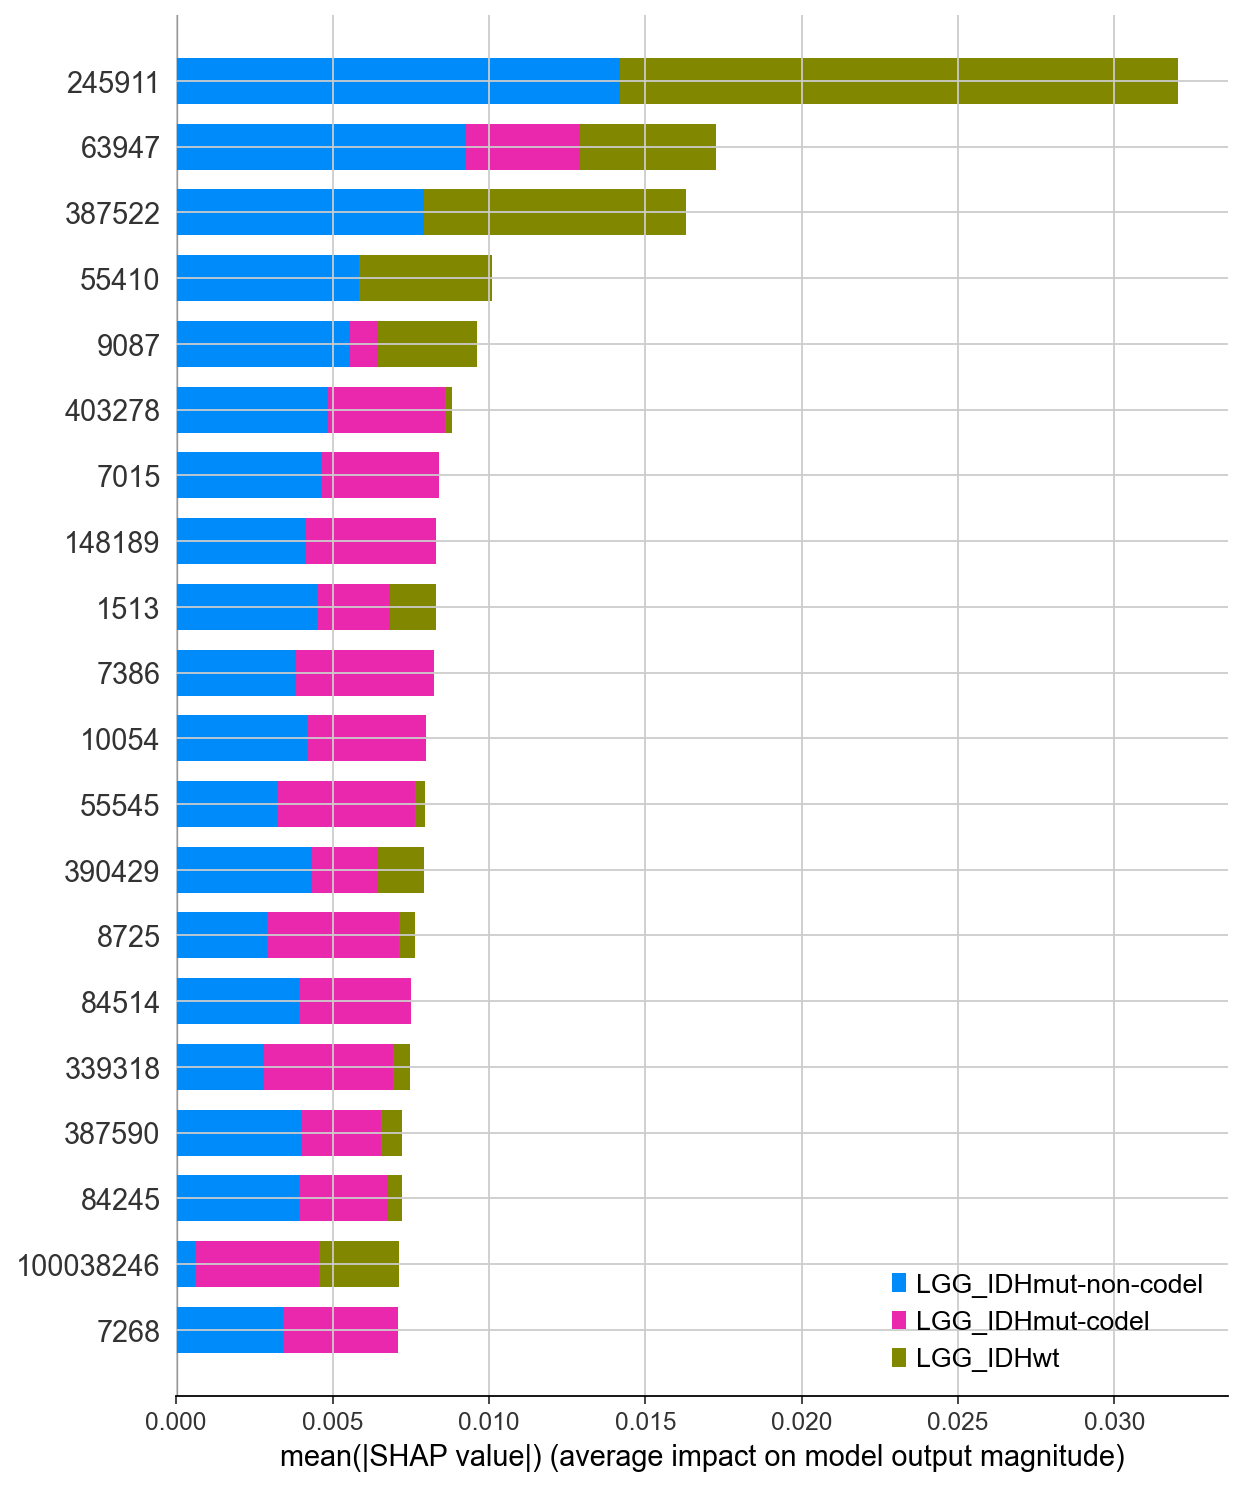

In [9]:
explainer = shap.Explainer(clf, X_train, feature_names=X.columns)
shap_values = explainer.shap_values(X_test)

# get the table for feature_importance
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns, sum(vals))), columns=['gene_id','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance = feature_importance.reset_index(drop=True)

# the plot for the data
class_names = ["LGG_IDHmut-non-codel", "LGG_IDHwt", "LGG_IDHmut-codel"]
shap.summary_plot(shap_values, X_train.values, plot_type="bar", class_names= class_names, feature_names = X.columns)

In [49]:
def get_gene_table(features):
# list of gene IDs

    # extract numerical characters from each element
    genes = []
    for element in features:
        # use regex to match digits (\d+)
        match = re.search(r'\d+', element)
        if match:
            genes.append(match.group())

    desc = []
    ids = []
    entrez_id_list = genes

    # email address to provide to NCBI
    Entrez.email = "your.email@example.com"

    # search for gene information for each ID
    for gene_id in entrez_id_list:
        try:
            handle = Entrez.efetch(db="gene", id=str(gene_id), retmode="xml")
            record = Entrez.read(handle)
            handle.close()
            description = record[0]["Entrezgene_summary"]  
            #name = record[0]["Entrezgene_gene"]  
        except:
            print(gene_id)
            description = np.nan

        # print gene ID and description
        ids.append(int(gene_id))
        desc.append(description)

    return pd.DataFrame(list(zip(ids,desc)), columns=['ID','Description'])

In [50]:
biodf = get_gene_table(list(feature_importance['gene_id'].astype(str))[:100])

55410
148189
55545
387590
100038246
378832
55108
391322
644873
283867
284749
115353
751867


In [58]:
top_n = 100
most_important_genes = pd.merge(feature_importance,biodf,
                                left_on='gene_id',
                                  right_on='ID')
n_most_important_genes = most_important_genes.nlargest(top_n, columns=['feature_importance_vals']).dropna(axis=0).reset_index(drop=True)
n_most_important_genes.head(10)

,gene_id,feature_importance_vals,ID,Description
0,245911,1.355439,245911,Defensins form a family of antimicrobial and c...
1,63947,0.730158,63947,Predicted to be involved in regulation of tran...
2,387522,0.690066,387522,The TMEM189-UEV mRNA is an infrequent but natu...
3,9087,0.406910,9087,This gene lies within the male specific region...
4,403278,0.372911,403278,Olfactory receptors interact with odorant mole...
5,7015,0.355953,7015,Telomerase is a ribonucleoprotein polymerase t...
6,1513,0.351118,1513,The protein encoded by this gene is a lysosoma...
7,7386,0.349320,7386,Predicted to enable oxidoreductase activity. I...
8,10054,0.337761,10054,Posttranslational modification of proteins by ...
9,390429,0.335313,390429,Olfactory receptors interact with odorant mole...


# pretrained BERT, encode descriptions

In [52]:
model = SentenceTransformer('emilyalsentzer/Bio_ClinicalBERT')

No sentence-transformers model found with name C:\Users\emile/.cache\torch\sentence_transformers\emilyalsentzer_Bio_ClinicalBERT. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\emile/.cache\torch\sentence_transformers\emilyalsentzer_Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a Bert

In [59]:
descriptions = n_most_important_genes['Description']
embeddings = model.encode(descriptions)

In [60]:
embeddings.shape

(87, 768)

# Reduce dim of embeddings then cluster

In [61]:
# Standardize the dataset X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(embeddings)

# Perform PCA on the standardized dataset X
pca = PCA(n_components=50)
pca.fit(X_scaled)


# Obtain the principal components and the explained variance ratios
principal_components = pca.transform(X_scaled)
explained_variance = pca.explained_variance_ratio_
print('explained variance is',explained_variance.sum())

# Create a new DataFrame with the principal components and the "cluster" column
df_pca = pd.DataFrame(data = principal_components)

explained variance is 0.92772603


In [62]:
tsne = TSNE()
embed = tsne.fit_transform(X_scaled)
# Create a new DataFrame with the principal components and the "cluster" column
df_embed = pd.DataFrame(data = embed, columns=['dim1','dim2'])

In [63]:
umapp = umap.UMAP()
embed = umapp.fit_transform(X_scaled)
df_embed = pd.DataFrame(data = embed, columns=['dim1','dim2'])

In [64]:

wcss_pca = []
wcss_umap = []
n_test = 20
# Perform k-means clustering for each k value from 1 to 10
for k in range(1, n_test):
    kmeans_pca = KMeans(n_clusters=k, init='k-means++', random_state=42).fit(df_pca)
    kmeans_umap = KMeans(n_clusters=k, init='k-means++', random_state=42).fit(embed)
    wcss_pca.append(kmeans_pca.inertia_)
    wcss_umap.append(kmeans_umap.inertia_)

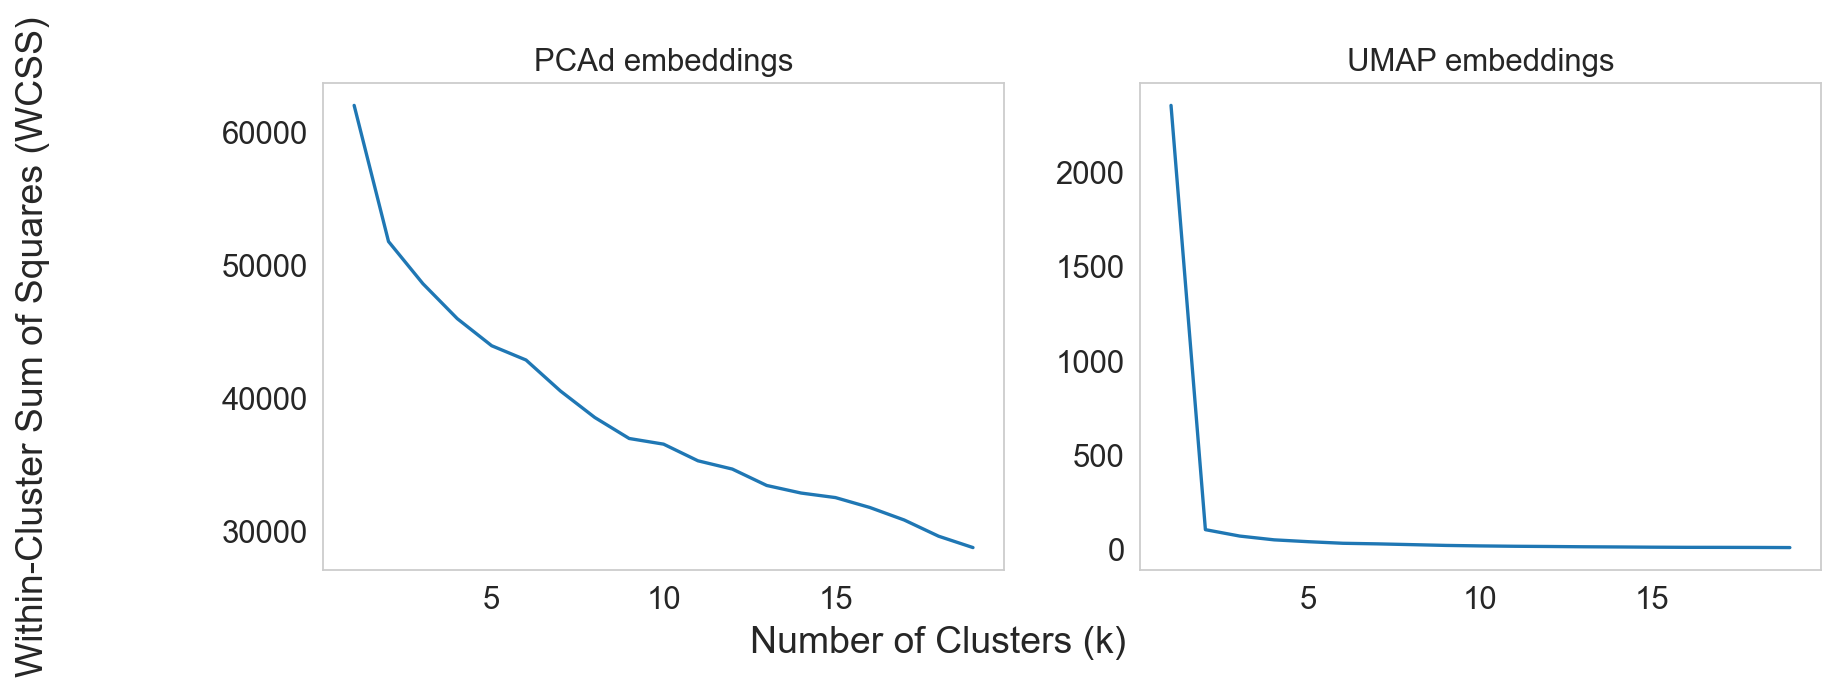

In [65]:
# Create a scree plot
fig, ax = plt.subplots(1,2,sharex=True, figsize=(12,4))
ax[0].plot(range(1, n_test), wcss_pca)
ax[1].plot(range(1, n_test), wcss_umap)
ax[0].set_title('PCAd embeddings')
ax[1].set_title('UMAP embeddings')
fig.supxlabel('Number of Clusters (k)')
fig.supylabel('Within-Cluster Sum of Squares (WCSS)')
#fig.suptitle('Scree Plot with embeddings')
plt.show()

# cluster

In [84]:
n_clusters = 2
X = X_scaled
kmeans = KMeans(n_clusters=n_clusters).fit(X)
labels = pd.DataFrame(kmeans.labels_, columns=['cluster'])

In [85]:
clusters_df = pd.concat([n_most_important_genes, df_embed, labels],axis=1)
clusters_df.groupby(by='cluster').count().iloc[:,0]


cluster
0    30
1    57
Name: gene_id, dtype: int64

## Looking at description

In [86]:

clusters_df[clusters_df['cluster']==0]

,gene_id,feature_importance_vals,ID,Description,dim1,dim2,cluster
1,63947,0.730158,63947,Predicted to be involved in regulation of tran...,6.810745,-7.961757,0
3,9087,0.406910,9087,This gene lies within the male specific region...,8.842951,1.869779,0
7,7386,0.349320,7386,Predicted to enable oxidoreductase activity. I...,6.059912,-9.158667,0
11,84514,0.318216,84514,Predicted to enable acid-amino acid ligase act...,7.816263,-8.582488,0
16,93010,0.292189,93010,Predicted to enable UDP-glycosyltransferase ac...,6.458435,-8.288227,0
20,390790,0.286767,390790,Predicted to enable GTP binding activity. Pred...,6.568273,-8.545585,0
24,149175,0.283331,149175,Predicted to enable alpha-mannosidase activity...,6.766930,-8.389278,0
25,56181,0.282618,56181,Predicted to be involved in aerobic respiratio...,7.018816,-8.652664,0
26,653567,0.279261,653567,Predicted to be integral component of membrane...,7.717706,-8.388936,0
29,400629,0.273968,400629,Predicted to enable piRNA binding activity. In...,7.019540,-8.157432,0


In [87]:
clusters_df[clusters_df['cluster']==1]

,gene_id,feature_importance_vals,ID,Description,dim1,dim2,cluster
0,245911,1.355439,245911,Defensins form a family of antimicrobial and c...,6.561429,1.664126,1
2,387522,0.690066,387522,The TMEM189-UEV mRNA is an infrequent but natu...,6.410235,3.169837,1
4,403278,0.372911,403278,Olfactory receptors interact with odorant mole...,6.658840,0.412178,1
5,7015,0.355953,7015,Telomerase is a ribonucleoprotein polymerase t...,5.702919,1.635971,1
6,1513,0.351118,1513,The protein encoded by this gene is a lysosoma...,6.869140,1.612592,1
8,10054,0.337761,10054,Posttranslational modification of proteins by ...,7.661574,3.184843,1
9,390429,0.335313,390429,Olfactory receptors interact with odorant mole...,6.490662,0.642636,1
10,8725,0.322612,8725,This gene encodes member of the prefoldin fami...,7.207540,1.644686,1
12,339318,0.316602,339318,Zinc finger proteins have been shown to intera...,8.224906,2.979461,1
13,84245,0.305084,84245,This enzyme functions in the methionine salvag...,7.079580,2.190332,1


In [88]:
clusters_df[clusters_df['cluster']==2]

,gene_id,feature_importance_vals,ID,Description,dim1,dim2,cluster


In [89]:
clusters_df[clusters_df['cluster']==3]

,gene_id,feature_importance_vals,ID,Description,dim1,dim2,cluster


In [90]:
clusters_df[clusters_df['cluster']==4]

,gene_id,feature_importance_vals,ID,Description,dim1,dim2,cluster


In [91]:
clusters_df[clusters_df['cluster']==5]

,gene_id,feature_importance_vals,ID,Description,dim1,dim2,cluster


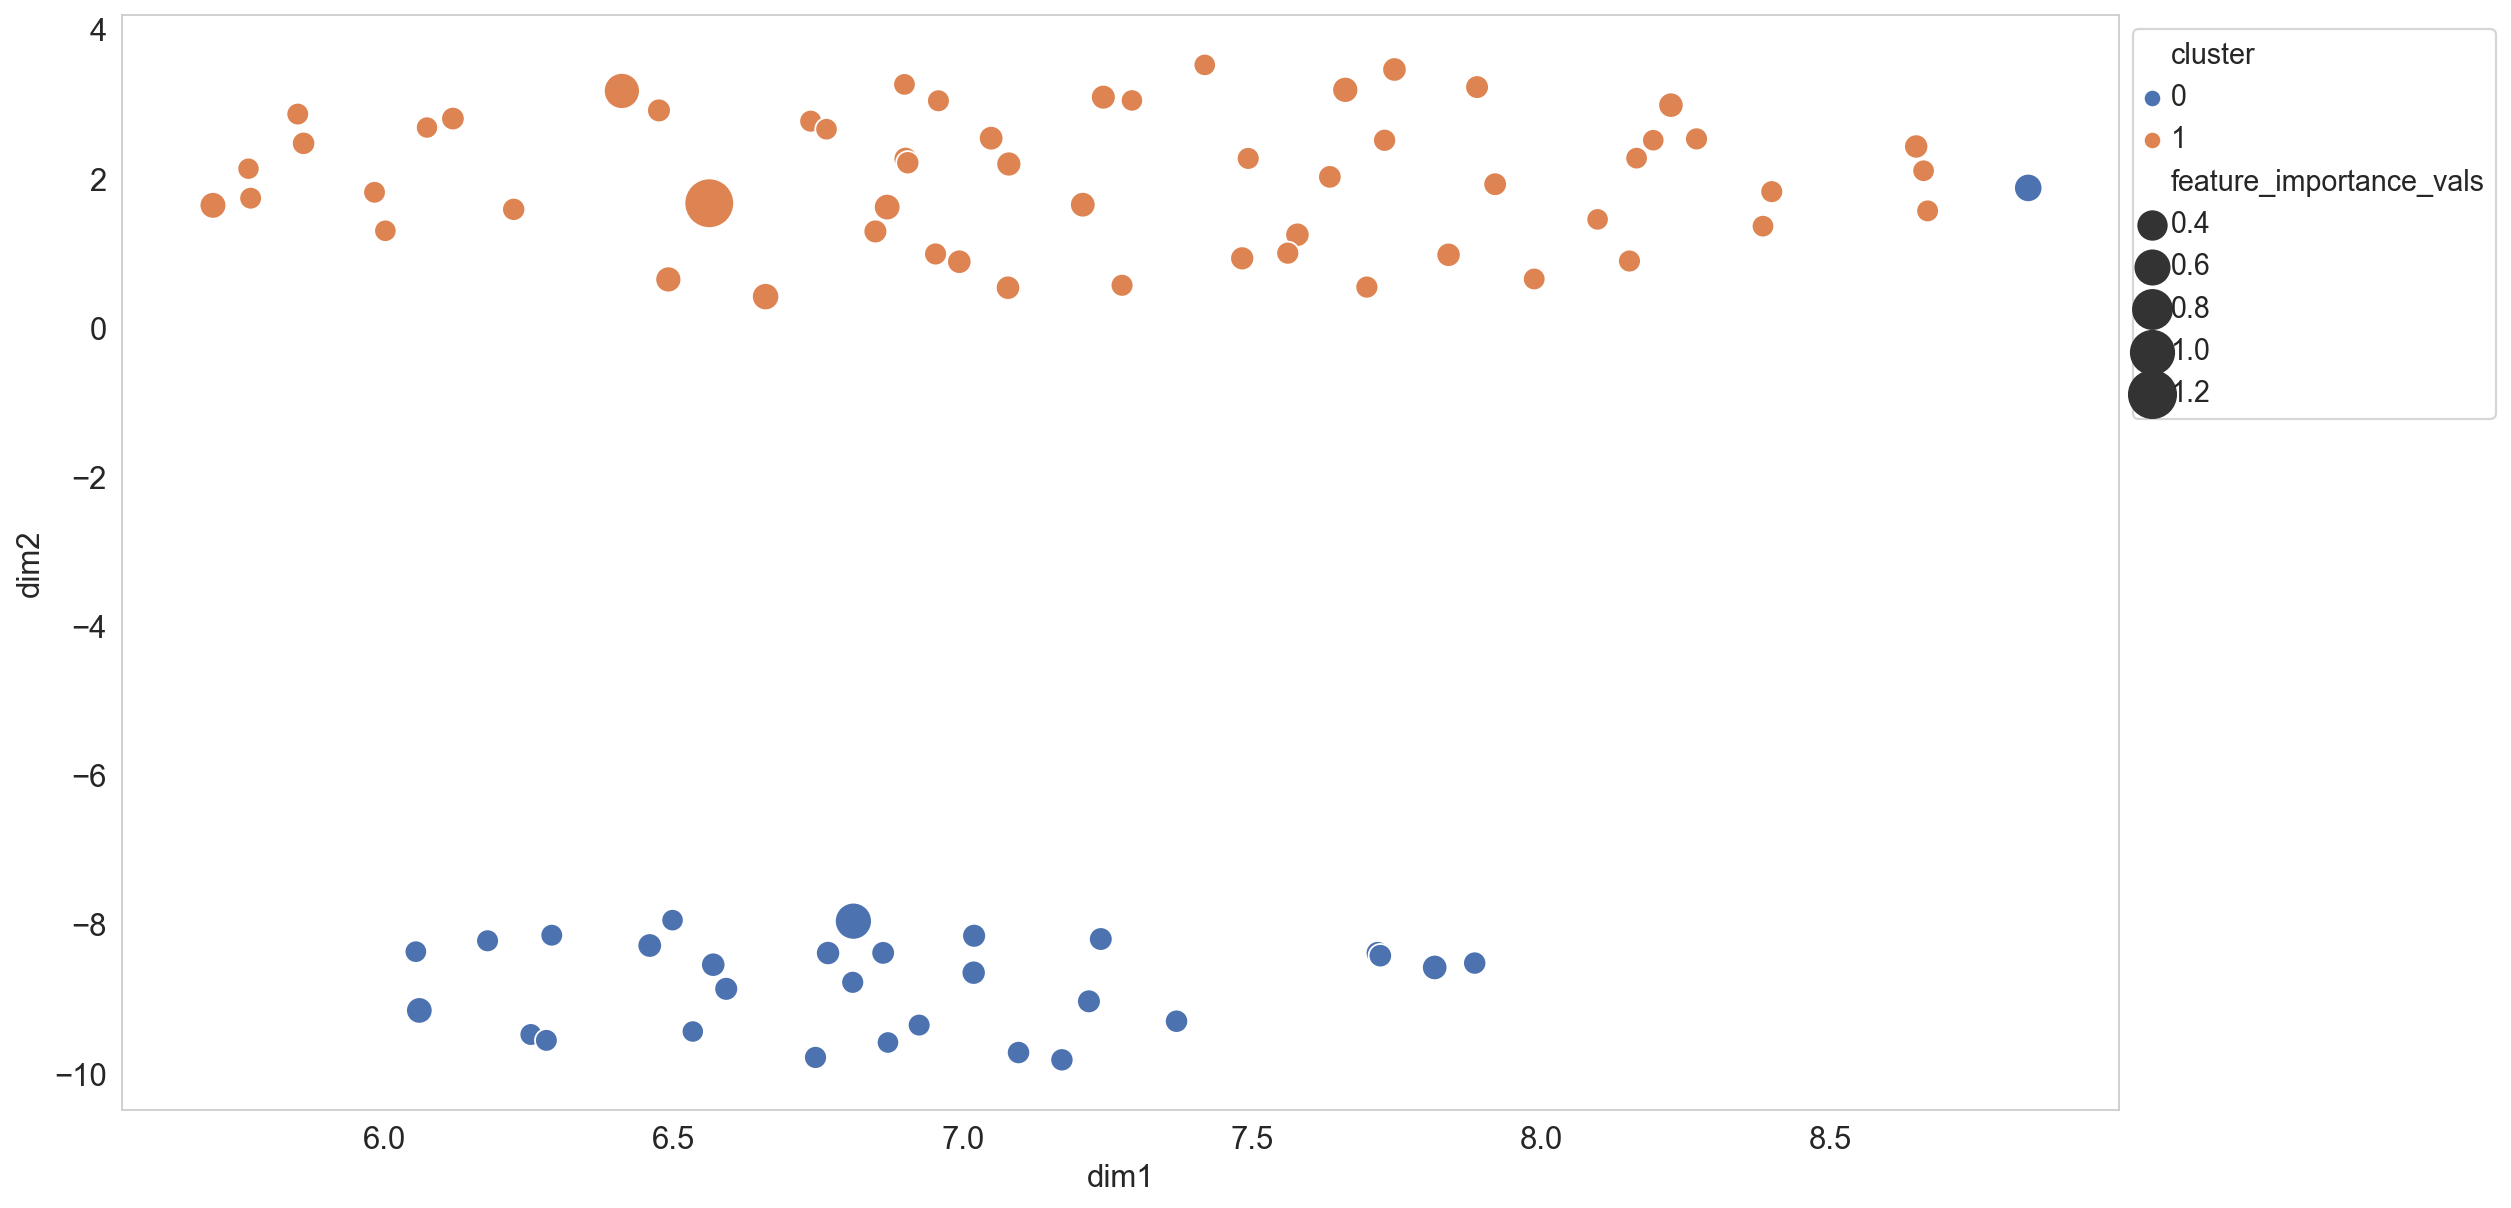

In [92]:
# Create a scatter plot of the principal components, colored by the "cluster" column
plt.figure(figsize=(16,9))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.scatterplot(data=clusters_df, x='dim1', y='dim2',
                     sizes=(100, 500),
                     palette='deep',
                      hue='cluster',
                        size='feature_importance_vals')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))